In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import math

In [2]:
# Excel-Daten einlesen (Angenommen, die Datei hat die Spalten "Unternehmen", "Branche", "Umsatz", "Kartell", "Strafe")
df = pd.read_excel("./data/Cartels.xls", sheet_name='Data_on_all_cartelfirms')



number_of_cases = df["Case:"].nunique()
number_of_cartels = df["Cartel:"].nunique()
number_of_entities = df["Entity Name"].nunique()

print("Number of cases: ", number_of_cases)
print("Number of Cartels: ", number_of_cartels)
print("Number of companies: ", number_of_entities)
df.head()

Number of cases:  76
Number of Cartels:  75
Number of companies:  229


,Case:,Cartel:,Entity Name,Key Iustin:,Year2010,Firm Name Mentioned in Commission Decision,Thomson (Rogier):,Key (invented by Iustin),Start-5,Start-4,...,market_sharing,marketing,information,Termination,Indicator Termination,Appeal,Upheld,Partial,Annulled,Reason
0,31865,PVC (II),Elf Aquitaine SA,C000007728,2010,Elf Aquitaine SA,Elf Aquitaine SA,31865C000007728,1976,1977,...,0.5,0.0,0.0,Commission Decision,1.0,1.0,0.0,1.0,0.0,0
1,31865,PVC (II),BASF SE,C000008351,2010,BASF SE,BASF SE,31865C000008351,1976,1977,...,0.5,0.0,0.0,Commission Decision,1.0,1.0,0.0,1.0,0.0,Duration
2,31865,PVC (II),Koninklijke DSM,C000013105,2010,Koninklijke DSM,Koninklijke DSM,31865C000013105,1976,1977,...,0.5,0.0,0.0,Commission Decision,1.0,1.0,0.0,1.0,0.0,Duration
3,31865,PVC (II),ENI,C901505544,2010,ENI,ENI,31865C901505544,1976,1977,...,0.5,0.0,0.0,Commission Decision,1.0,1.0,0.0,1.0,0.0,Duration
4,31865,PVC (II),Wacker Chemie AG,C901711026,2010,Wacker Chemie AG,Wacker Chemie AG,31865C901711026,1976,1977,...,0.5,0.0,0.0,Commission Decision,1.0,1.0,0.0,1.0,0.0,Duration


In [19]:
# Unternehmen und Kartelle speichern
entity_list = []
entity_set = set()  # Set zur schnellen Überprüfung

cartel_list = []
cartel_set = set() # Set zur schnellen Überprüfung

edge_list = []

for _, row in df.iterrows():
    # Entities 
    if row["Entity Name"] not in entity_set:
        entity_list.append({
            "Entity": row["Entity Name"],
            "Key Iustin": row["Key Iustin:"],
            "Firm Name": row["Firm Name Mentioned in Commission Decision"],
            "Sales": row["Sales"], # Can be Null
            "Market Share": row["Market_Share"] # Can be Null
        })
        entity_set.add(row["Entity Name"])  # Add to set for quicker check if already added

    # Kartelle
    if row["Cartel:"] not in cartel_set:
        cartel_list.append({
            "Cartel": row["Cartel:"],
            "Startyear": row["Start:"],
            "Duration": row["Duration"],
            "Number of Firms": row["Number of Firms"],
            "Sector": row["Sector"],
            "Market Share Cartel": row["Market_Share_Cartel"]
        })
        cartel_set.add(row["Cartel:"])  # In das Set aufnehmen

    #Edges
    edge_list.append((row["Entity Name"], row["Cartel:"]))


print(entity_list)
print(cartel_list)
print(edge_list)

[{'Entity': 'Elf Aquitaine SA', 'Key Iustin': 'C000007728', 'Firm Name': 'Elf Aquitaine SA', 'Sales': 0.01776520640472492, 'Market Share': 11.7}, {'Entity': 'BASF SE', 'Key Iustin': 'C000008351', 'Firm Name': 'BASF SE', 'Sales': 0.039939908005327006, 'Market Share': 6}, {'Entity': 'Koninklijke DSM', 'Key Iustin': 'C000013105', 'Firm Name': 'Koninklijke DSM', 'Sales': 0.023404715544305968, 'Market Share': 7.1}, {'Entity': 'ENI', 'Key Iustin': 'C901505544', 'Firm Name': 'ENI', 'Sales': nan, 'Market Share': 13.9}, {'Entity': 'Wacker Chemie AG', 'Key Iustin': 'C901711026', 'Firm Name': 'Wacker Chemie AG', 'Sales': 0.34181012461137245, 'Market Share': 6}, {'Entity': 'Royal Dutch Shell', 'Key Iustin': 'C901842957', 'Firm Name': 'Royal Dutch Shell', 'Sales': nan, 'Market Share': 6.3}, {'Entity': 'PPG Industries Inc', 'Key Iustin': 'C000003476', 'Firm Name': 'Vernante Pennitalia SpA', 'Sales': nan, 'Market Share': nan}, {'Entity': 'Saint Gobain', 'Key Iustin': 'C000007729', 'Firm Name': 'Fabbr

In [21]:
# Erstelle einen Graphen
G = nx.Graph()

# Füge Unternehmen als Typ Unternehmung hinzu
for entity in entity_list:
    G.add_node(entity["Entity"], type="Company", bipartite=0)

# Füge Kartelle als Typ Kartell hinzu
for cartel in cartel_list:
    G.add_node(cartel["Cartel"], type="Cartel", bipartite=1)

# Füge Edges hinzu
G.add_edges_from(edge_list)

In [27]:
# Set Company Nodes and Cartel Nodes for bipartite layout
company_nodes = {node for node, attributes in G.nodes(data=True) if attributes["bipartite"] == 0}
cartel_nodes = {node for node, attributes in G.nodes(data=True) if attributes["bipartite"] == 1}

{'Galp', 'Akzo Nobel', 'Saint Gobain', 'BASF SE', 'Archer-Daniels-Midland Company', 'Halcor SA', 'Chemtura Corp.', 'Neptune Orient Lines Limited', 'Alstom SA', 'Hitachi Ltd.', 'Mitsubishi Tanabe Pharma', 'Chemtura', 'Tecumseh Products Company', 'KME Group', 'Lonza Group', 'Koninklijke BAM Groep NV', 'AGIE CHARMILLES HOLDING AG', 'Sanofi-Aventis', 'NEC Corporation', 'Ajinomoto Company Inc', 'Inbev SA', 'Cementir Holding', 'Repsol', 'Nynas', 'ArcelorMittal', 'Commerzbank AG', "Sotheby's", 'Koninklijke Grolsch NV', 'KLM', 'CSX Corp.', 'Groupe Danone', 'Linde AG', 'BPB PLC', 'KERR-MCGEE CORPORATION', 'Tenneco Inc', 'Siemens AG', 'Unilever PLC', 'Trelleborg', 'Tate & Lyle PLC', 'Mitsui Osk Lines Limited', 'Chiquita Brands International, Inc.,', 'Sumitomo Chemical Company Limited', 'AVENTIS SA', 'DMC (Dollfus Mieg)', 'Ballast Nedam NV', 'Infineon', 'UCAR CARBON S/A', 'SAS AB', 'Raiffeisen International Bank Holding AG', 'Samsung', 'Denka', 'Hyundai Merchant Marine', 'Manuli', 'HICKING PENTEC

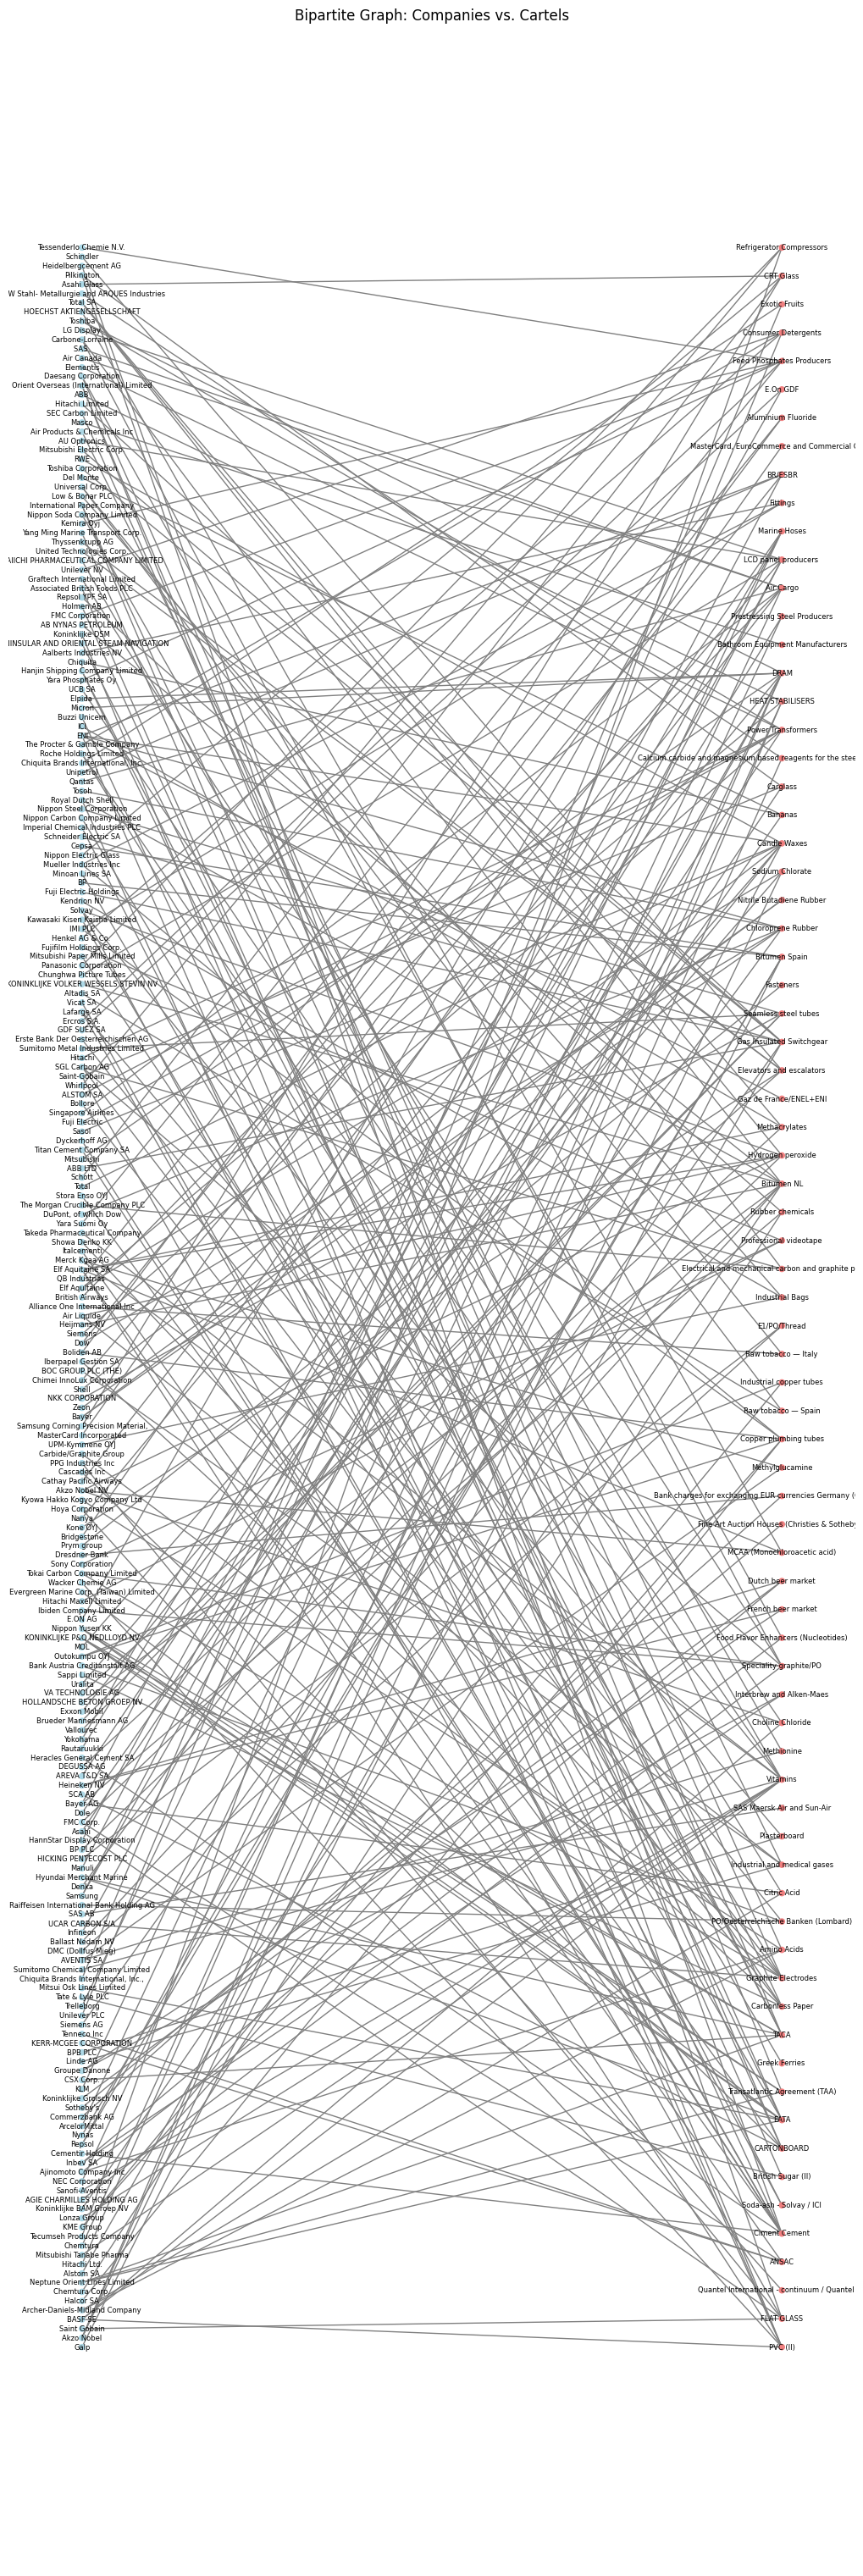

In [49]:
# Berechne das Layout für den bipartiten Graphen
pos = nx.bipartite_layout(G, company_nodes)

# Visualisierung
plt.figure(figsize=(10, 30))

node_colors = []

for node, attribute in G.nodes(data=True):
    if attribute.get("type") == "Company":
        node_colors.append('lightblue')
    elif attribute.get("type") == "Cartel":
        node_colors.append('lightcoral')
    else:
        node_colors.append('gray')
    
nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color="gray", node_size=20, font_size=6)
plt.title("Bipartite Graph: Companies vs. Cartels")
plt.show()

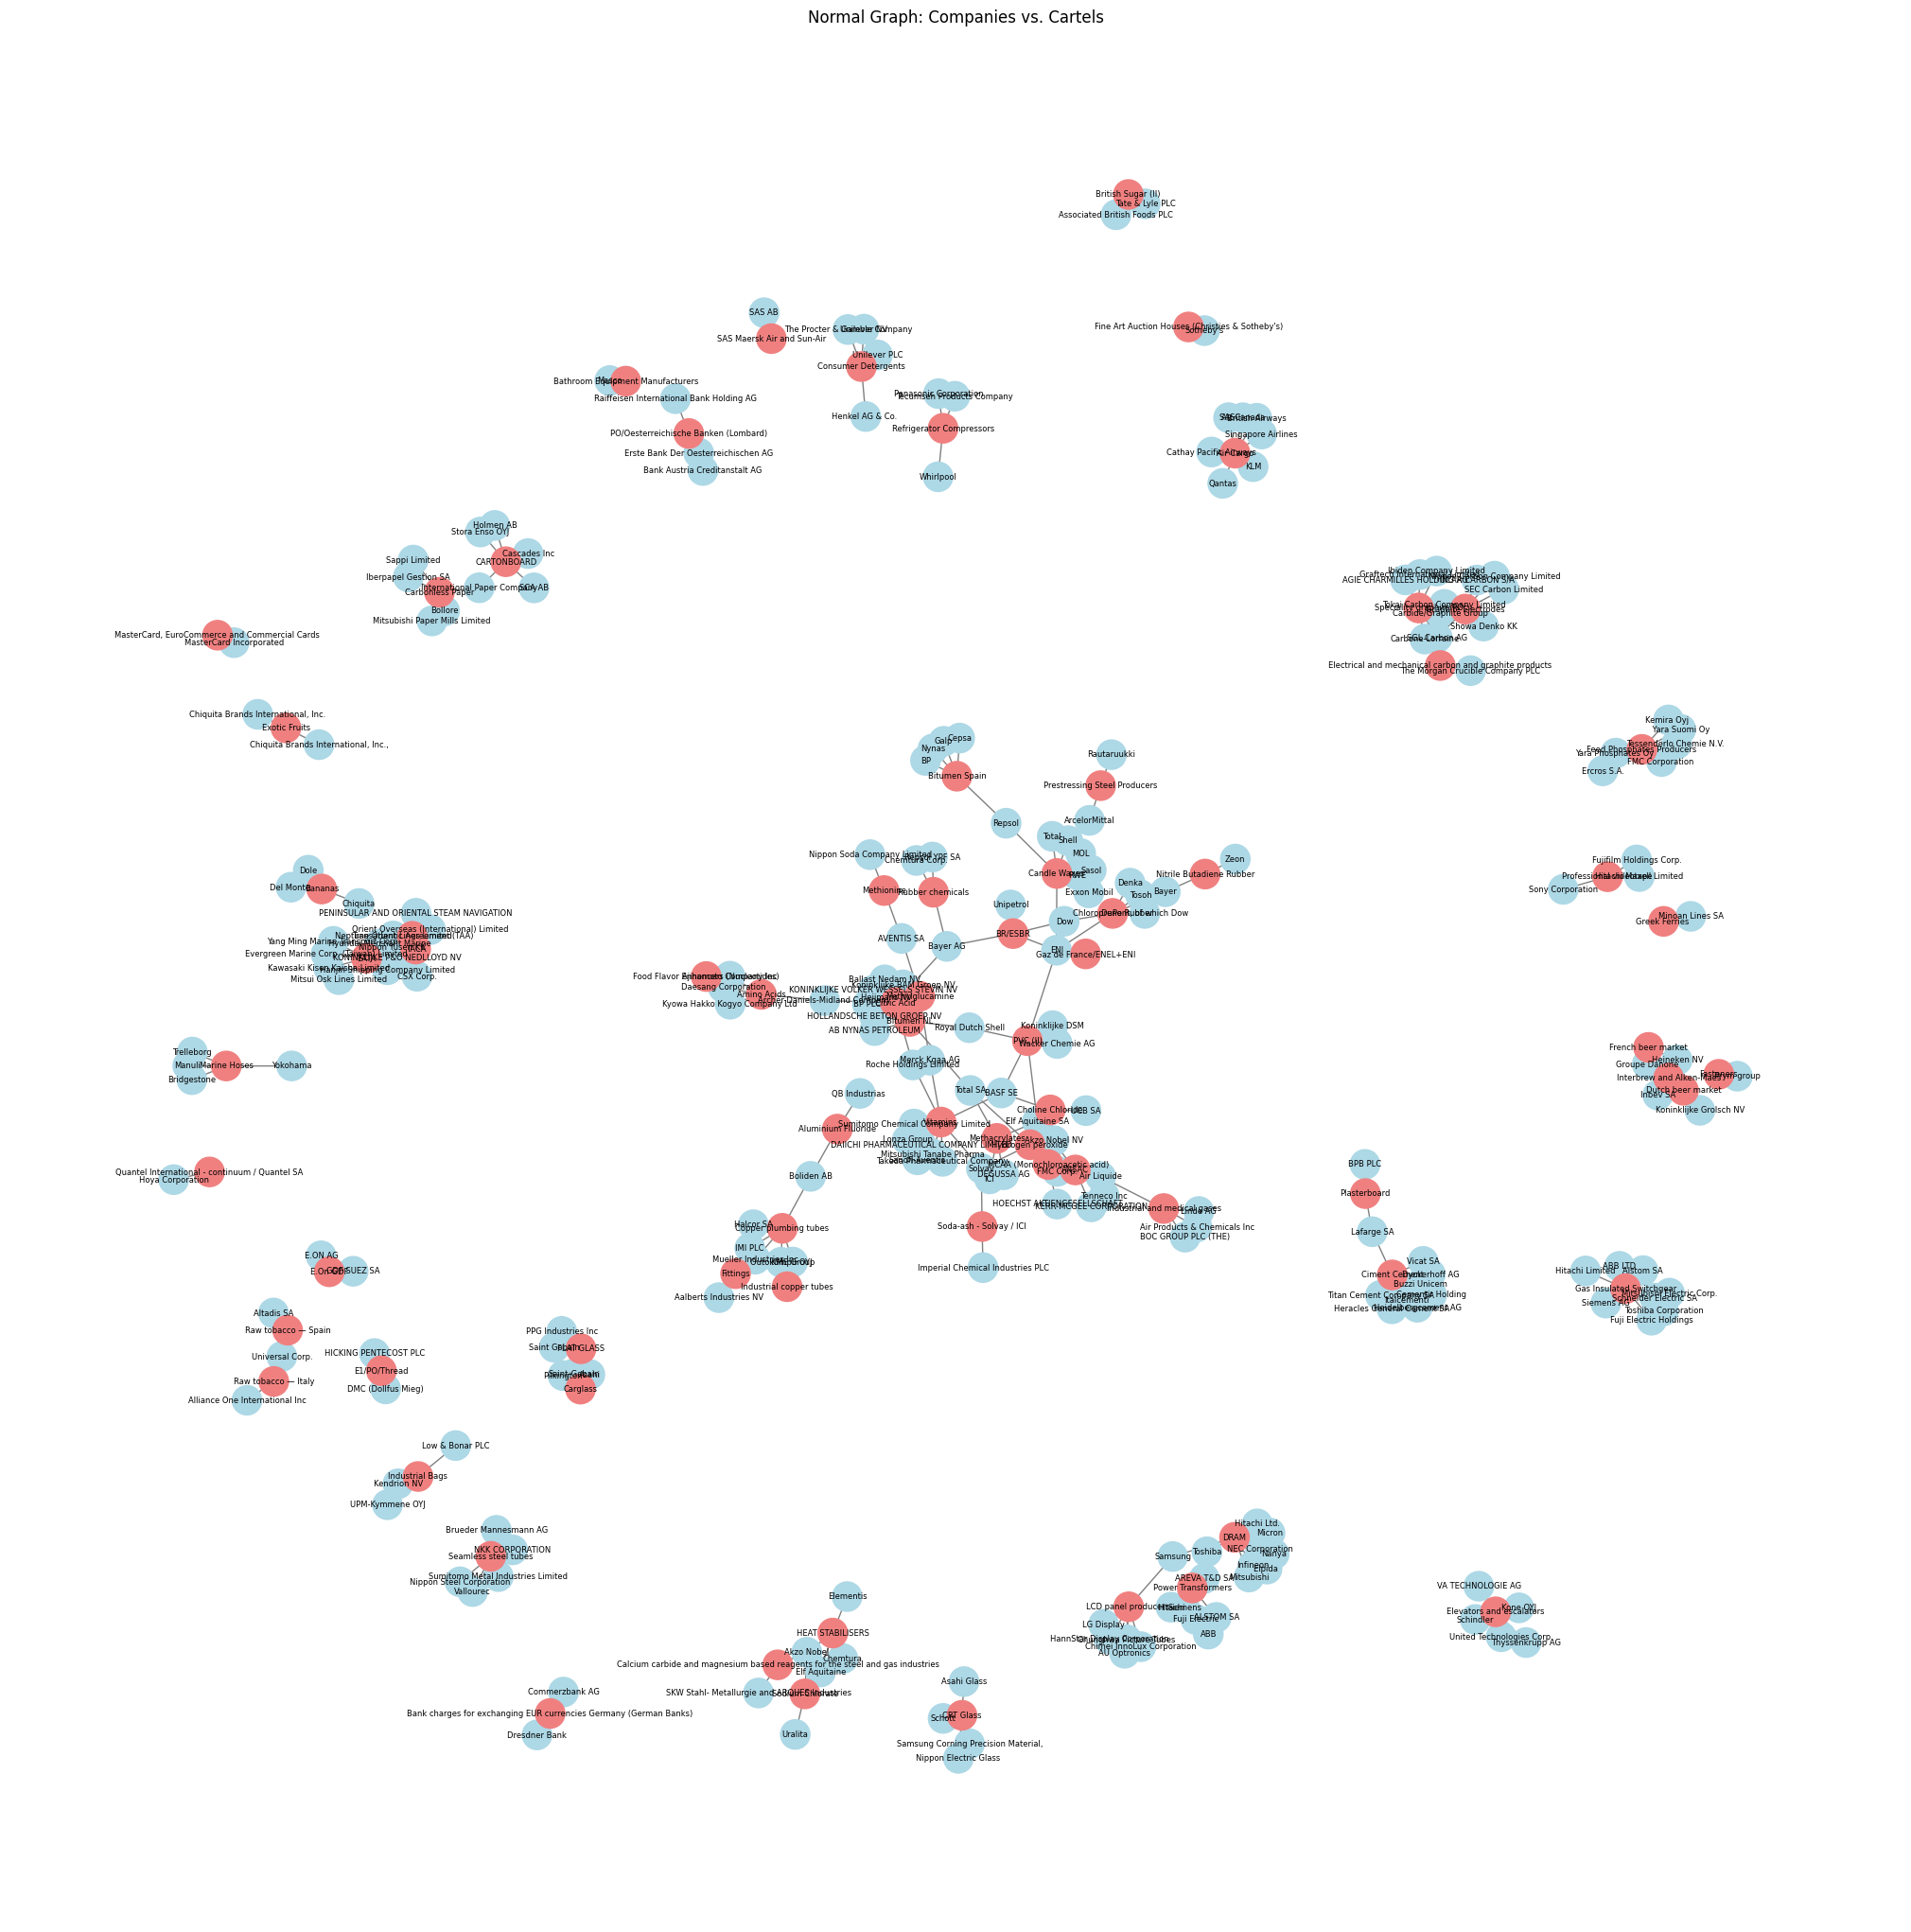

In [56]:
# Visualisierung
plt.figure(figsize=(20, 20))

nx.draw(G, with_labels=True, node_color=node_colors, edge_color="gray", node_size=500, font_size=6)
plt.title("Normal Graph: Companies vs. Cartels")
plt.show()

In [77]:
# Zentralitätsmetriken berechnen
centrality_measures = {
    "Degree Centrality": nx.degree_centrality(G),
    "Betweenness Centrality": nx.betweenness_centrality(G),
    "Closeness Centrality": nx.closeness_centrality(G),
    "Eigenvector Centrality": nx.eigenvector_centrality(G),
    "PageRank": nx.pagerank(G),
    "Harmonic Centrality": nx.harmonic_centrality(G),
    "Degrees": dict(G.degree())
}

# Daten für Unternehmen und Kartelle in DataFrames umwandeln
company_centrality = []
cartel_centrality = []

for node in G.nodes(data=True):
    node_name, attributes = node
    node_type = attributes["type"]

    centrality_data = {
        "Name": node_name,
        "Degree Centrality": centrality_measures["Degree Centrality"].get(node_name, 0),
        "Betweenness Centrality": centrality_measures["Betweenness Centrality"].get(node_name, 0),
        "Closeness Centrality": centrality_measures["Closeness Centrality"].get(node_name, 0),
        "Eigenvector Centrality": centrality_measures["Eigenvector Centrality"].get(node_name, 0),
        "PageRank": centrality_measures["PageRank"].get(node_name, 0),
        "Harmonic Centrality": centrality_measures["Harmonic Centrality"].get(node_name, 0),
        "Degrees": centrality_measures["Degrees"].get(node_name, 0)
    }

    if node_type == "Company":
        company_centrality.append(centrality_data)
    elif node_type == "Cartel":
        cartel_centrality.append(centrality_data)

# DataFrames erstellen
df_cartel_centrality = pd.DataFrame(cartel_centrality).add_prefix('Cartel ')
df_company_centrality = pd.DataFrame(company_centrality).add_prefix('Company ')

df_company_centrality.head()



,Company Name,Company Degree Centrality,Company Betweenness Centrality,Company Closeness Centrality,Company Eigenvector Centrality,Company PageRank,Company Harmonic Centrality,Company Degrees
0,Elf Aquitaine SA,0.016502,0.017079,0.070142,0.000148,0.006032,27.396825,5
1,BASF SE,0.009901,0.014818,0.072772,0.000107,0.003885,26.676190,3
2,Koninklijke DSM,0.003300,0.000000,0.062600,0.000040,0.001569,21.630159,1
3,ENI,0.016502,0.036346,0.077110,0.000091,0.006563,29.210714,5
4,Wacker Chemie AG,0.003300,0.000000,0.062600,0.000040,0.001569,21.630159,1


In [80]:
print(df_cartel_centrality.columns)

df_cartel_enriched = df.merge(df_cartel_centrality, 'left', left_on=["Cartel:"], right_on=["Cartel Name"]).merge(df_company_centrality, 'left', left_on=["Entity Name"], right_on=["Company Name"])

df_cartel_enriched.to_excel("./centrality_data/cartel_centralities.xlsx")

Index(['Cartel Name', 'Cartel Degree Centrality',
       'Cartel Betweenness Centrality', 'Cartel Closeness Centrality',
       'Cartel Eigenvector Centrality', 'Cartel PageRank',
       'Cartel Harmonic Centrality', 'Cartel Degrees'],
      dtype='object')
